In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
from scipy import constants
import math

Here are a bunch of Python versions of functions from the Schrier book Ch. 11. I am skipping the coin flip early parts and going straight to the work using the energy levels of a quantum harmonic oscillator (which is the model for a single vibrational degree of freedom).  Big acknowledgments to TAs from Chem 304 fall 2022, who coded many of these functions originally.

Here is the "exact solution" with evaluation (as on p. 281):

In [2]:
# the energies in this system: harmonic oscillator, with frequency and kT scaled vs each other
def energyVibDiatomic(hbarOmega,v):
    return hbarOmega*(v+0.5)

# the exact vibrational partition function for one mode, from McQuarrie
def qExact(kT,hbarOmega):
    """calculate the exact value of the partition function"""
    v = sy.symbols('v')
    return sy.N(sy.Sum(sy.exp(-energyVibDiatomic(hbarOmega,v)/kT), (v, 0, sy.oo))) # Summation from 0 to infinity

# the analytical probability of any state v, using the known probability distribution
def exactProbResult(kT,hbarOmega,v):
 return sy.N(sy.exp(-energyVibDiatomic(hbarOmega,v)/kT)/qExact(kT,hbarOmega))

In [3]:
print("Here is the probability to be in v=0:", exactProbResult(1,1,0))
print("Calculation of our Partition Function at kT=1 and hbaromega=1:",qExact(1,1))

Here is the probability to be in v=0: 0.632120558828558
Calculation of our Partition Function at kT=1 and hbaromega=1: 0.959517375667472


Now here are the functions that we need to run the Monte Carlo simulation. We need both a function that runs a single step and a routine that can run a simulation with a specified starting point, equilibration period, and number of steps with specification of how often to write out the result. Then we also need a counting routine that can tell us how many of a specific outcome we had (i.e. how many v=2 states did we see?).

In [4]:
#Needed functions from Schrier text: python versions

def count(samples, entry):
  """making a python equivalent for the Mathematica "Count[]" function.
  "samples" should be your list of samples.
  "entry" should be which kind of entry you'd like to code to count for you.
  these are the same inputs that the Mathematica function would expect."""
  items, counts = np.unique(samples, axis=0, return_counts=True) # tally
  for i in range(len(items)):
    if np.array_equal(items[i],entry):
      return counts[i]

# taking one step in a Monte Carlo simulation: arguments are
# kT and frequency for this system (scaled to each other in the same energy units),
# and then a starting state of the system
# before each step, which here is "v" or the quantum number
def MCstep(kT,hbarOmega,v):
    vprime = np.maximum(v+(-1)**np.random.randint(2), 0)
    deltaE = energyVibDiatomic(hbarOmega,vprime) - energyVibDiatomic(hbarOmega,v)
    if deltaE <= 0:
      return vprime
    else:
      randn = np.random.random()
      if randn < np.exp(-deltaE/kT):
        return vprime
      else:
        return v

# this sets up a working Monte Carlo simulation by taking a bunch of "MCSteps"
# subject to specific arguments
# kT and the frequency are here, scaled to each other, as well as
# nEquil which is how many steps to take before recording any data and
# nDataCol, which is the total number of steps
# by default this writes the result of every 100th step (but that could be edited)
def runMC(kT, hbarOmega, nEquil, nDataCol):
    """
    Run a Monte Carlo simulation of the Harmonic Oscillator energy levels for some number of steps
    """
    v = 0
    vSamples = []
    for i in range(nDataCol):
        v = MCstep(kT, hbarOmega, v)
        if i%100 == 0:
            vSamples.append(v)
    return vSamples

# this takes an outputted list of data (which is just a bunch of v's in this system)
# and calculates probability by counting some outcome
# vSamples here is the data, and vTarget here is the outcome of interest (i.e. v=0)
def MCProbResult(vSamples, vTarget):
    """
    Calculate the probability of an energy level given data from a
    Monte Carlo simulation.
    """
    return count(vSamples, vTarget)/len(vSamples)

With all of those functions on board, let's take 20 steps and see what the outcomes look like.

In [5]:
"""
Below we do a Monte Carlo step where we print out the v we find ourselves in.
"""

v=0 
steps = []
N=20
for i in range(N):
  v=MCstep(1,1,v)
  steps.append(v)

print("Here are our steps when we start at v=0:\n", steps)


Here are our steps when we start at v=0:
 [0, 0, 0, 1, 1, 1, 2, 1, 0, 1, 0, 0, 0, 1, 2, 3, 2, 1, 1, 1]


You can see that the value of *v* is effectively fluctuating with each step, which means that the simulation works for each step (it should be randomly picking new quantum numbers and then moving based on weighted probabilities that we defined above). But you can also see that there is some strong dependence of each outcome on what the prior value was, which is **NOT** what we want if we are doing MC simulations which are supposed to provide accurate statistical weighting of outcomes.

So now let's run a short simulation where we take 10000 steps and write out every 100th step.

In [6]:
simlist = runMC(1,1,100,10000)
print(simlist)


[0, 0, 0, 3, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 1, 2, 4, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0]


So that also works, and hopefully you can see now that the sampled outcomes don't depend strongly on each other consecutively. From that simulation, we can figure out how many of each quantum number we observed and what the probability of that quantum number was. (Here are two ways to output that number: one uses the "MCProbResult" function from the Schrier book.)

In [7]:
# Calculation of likelyihood of being in v=0
sy.N(count(simlist,0)/len(simlist))

0.710000000000000

In [8]:
# Using the function MCProbResult that uses the count functions
MCProbResult(simlist, 0)

0.71

This is close to, but not exactly the same as, the exact result for v=0 that we expect.  If you re-run the last two input cells, you will see that the counted probability from the simulation fluctuates around the expected result. (We have now made it through p. 283 in the Schrier text.)

Now we can test convergence of the simulation to the actual result (as happens on p. 284 of the text). The point here is to show that as we add more and more sampling points (running longer and longer simulations) that the result converges to the expected, analytical result for this system.

Please note that this cell will take a while (maybe 30 seconds of cloud runtime) since it is running simulations with longer and longer numbers of steps.  (You can un-comment the last line if you want to see the actual numerical results, which here are sampled probabilities for $v=0$ for longer and longer intervals. But please only run the cell once.)

In [9]:
kT = 1
hbarOmega = 1
convergenceTest = [] #dont change this; re-initializes the list of outcomes
for nDataCol in np.arange(1000,100000,2000): #dont change this; this specifies how many simulations
    convergenceTest.append(MCProbResult(runMC(kT,hbarOmega,100,nDataCol),0)) #put something in here to append to the list
# convergenceTest

Now let's make a plot to show convergence, as on p. 284 where the converging probability is plotted with a horizontal line at the expected outcome (from the exact result).

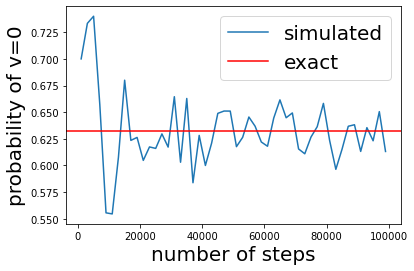

In [10]:
plt.plot(np.arange(1000,100000,2000),convergenceTest,label='simulated')
plt.axhline(exactProbResult(1,1,0), color='r', linestyle='-',label='exact') #plot a horizontal line at the exact value
plt.xlabel("number of steps",fontsize=20)
plt.ylabel("probability of v=0",fontsize=20)
plt.legend(fontsize=20)

What we showed there is that as the simulations get longer (closer to infinite length), we get non-flucuating, essentially exact results for sampling in our system.  This means that we could use simulations to figure everything out about a system as long as we know what the rules are for that system (meaning, all of the possible energies and their relative probabilities).

Below are problems that we will do in class.  Please wait until we start these in class together.


# \# 11-2

##### Collaborators: Kyla Hayes, Sydney, Abby

### \# Part 1



On a board or paper, write down the equation (or existing function) you would need to solve and/or plug numbers into to find the probability of a harmonic oscillator being in the $v=1$ state.

In [11]:
""" Below is the equation that we are using! It is from the first definition of the function we got: """

' Below is the equation that we are using! It is from the first definition of the function we got: '

Here is the equation! 
$$p_{v=1}=\frac{e^{-\varepsilon _1 /k_BT}}{\sum_i e^{-\varepsilon _i /k_BT}}=\frac{e^{-\varepsilon _1 /k_BT}}{Q}$$
Where this is just the Boltzman distribution of $\varepsilon_1$ divided by the Partition Function. 

### \# Part 2

Add some input to the second cell to calculate the exact probability of a quantum harmonic oscillator being in the $v=1$ state at a temperature of $kT/\hbar\omega=1$.

In [12]:
exactProbResult(1,1,1)

print("The exact probability of being in v = 1:", exactProbResult(1,1,1))

The exact probability of being in v = 1: 0.232544157934830


### \# Part 3

On a board or paper, draw a diagram or write pseudocode describing how you might use the functions in the second cell to run a Monte Carlo simulation with an equilibration period of 1000 steps and a data collection period of 10,000 steps at a temperature of $kT/\hbar\omega=1$.

### \# Part 4

Use the functions in the second cell to run a Monte Carlo simulation with an equilibration period of 1000 steps and a data collection period of 10,000 steps at a temperature of $kT/\hbar\omega=1$.

Use the data collected in this simulation to provide an estimate the probability of the $v=1$ state under these conditions. Feel free to see how much this number fluctuates in multiple trials of the same length.

In [13]:
simlist = runMC(1,1,1000,10000) # Run Monte Carlo Simulation with neqil = 1000, and collection period = 10,000
print(simlist) # Print out the list
print("Given simlist, probability of being in v=1 is", MCProbResult(simlist, 1))

[0, 2, 0, 2, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 2, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 0, 0, 2, 1, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 9, 1, 1, 0, 0, 0, 0, 0, 1, 2, 1, 3, 1, 0, 0, 1, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
Given simlist, probability of being in v=1 is 0.24


### \# Part 5

Collect the simulated probabilities from your group members in the following cell. Is their average closer to or further from the exact value than your individual answers?

In [14]:
np.mean([0.22,0.26,0.21]) #take the average of your group members' simulated probabilities

0.22999999999999998

### \# Part 6

On a board, draw a diagram or write pseudocode describing how you might use the functions in the second cell to demonstrate convergence of your simulation predictions as the number of data collection steps increases.

### \# Part 7

Complete or edit the code in the following cell to demonstrate convergence of your simulation predictions as the number of data collection steps increases.

Remember, you're trying to predict the probability of the $v=1$ state at a temperature of $kT/\hbar\omega=1$.

In [15]:
kT = 1
hbarOmega = 1
convergenceTest = [] #dont change this; re-initializes the list of outcomes
for nDataCol in np.arange(1000,100000,2000): #dont change this; this specifies how many simulations
    convergenceTest.append(MCProbResult(runMC(kT,hbarOmega,1000,nDataCol),1)) #put something in here to append to the list
# convergenceTest

### \# Part 8

Complete the code below to plot the results of your simulations. Include a horizontal line at the value of the exact probability of the $v=1$ state. What happens as the number of data collection steps increases?


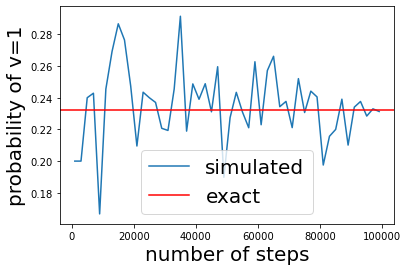

In [16]:
plt.plot(np.arange(1000,100000,2000),convergenceTest,label='simulated')
plt.axhline(exactProbResult(1,1,1), color='r', linestyle='-',label='exact') #plot a horizontal line at the exact value
plt.xlabel("number of steps",fontsize=20)
plt.ylabel("probability of v=1",fontsize=20)
plt.legend(fontsize=20)

# \# 11-3

Now let's try 11-3, which asks you to find the mean value of *v* for your simulation, rather than the probability of some specific *v*.

### \# Part 1

Use the code box below to define a function that calculates the mean of your simulated outcomes from a given list. Call the list "vSamples", and see above for input that tells you how numpy calculates the mean of a list.

In [17]:
"""
Function: list_mean
Input: vSamples (list)
Output: np.mean(vSamples) (float)
Task: takes in a simulated list of outcomes, and then uses the numpy function .mean() to calculate the mean of that list. 
"""

def list_mean(vSamples):
    return np.mean(vSamples)
list_mean(convergenceTest) # Calculates the mean of the v=1 convergence probabilities from above. 

0.23513520527763138

### \# Part 2

Now run a simulation at $kT=1$ and $\hbar\omega=1$ with an equilibration period of 1000 steps and a data collection period of 10,000 steps, and calculate the mean $v$ outcome.

In [18]:
v=0
steps = []
N=10000
# Does a MC simulation where we record every 1000th step. 
for i in range(N):
  v = MCstep(1, 1, v)
  if i%1000 == 0:
    steps.append(v)

print(steps)
print("The mean of v is", list_mean(steps))

[0, 0, 1, 1, 1, 3, 0, 0, 0, 0]
The mean of v is 0.6


### \# Part 3

To test convergence here, we need to compare to the exact result. What is the exact result for the mean of $v$ at any possible $kT$ and $\hbar\omega$? Define a function that will return this numerical value if you give it $kT$ and $\hbar\omega$. (Big hint: you may also be able to use the input associated with the "qExact" function from above to help you with this.)

In [19]:
import math
"""
Function: meanExact
Inputs: kT (float), hbarOmega (float)
Outputs: list_mean(list) (float)

Task: Takes in the inputs kT, hbaromega and uses those values to calculate exactProbResult(kT,hbarOmega,n)
for the first 1000 n values of Vibrational energies. We then use that value of exactProbResult(kT,hbarOmega,n)
and add 1000 iterations into a list of that result. i.e., if we calculate the probability of exactProbResult(kT,hbarOmega,0)
to be 50.00%, we add 5000 0's into a list. We do that for v=0 to v=1000. We then calculate the mean of that list to get our 
exact mean. 
"""

def meanExact(kT,hbarOmega):
    """calculate the exact mean from any kT,hbarOmega for vibrational energy"""
    list = [] # list to hold large amount of values
    for n in range(1000):
        value = math.trunc(exactProbResult(kT,hbarOmega,n)*1000) # creating number of iterations of n probability number
        list += [n] * value
    return list_mean(list) # Summation from 0 to infinity

In [20]:
print("The exact mean for v when kT=1 and hbarOmega=1 is",meanExact(1,1))

The exact mean for v when kT=1 and hbarOmega=1 is 0.5672690763052208


### \# Part 4

Now run a series of longer simulations (analogous to what happened in Part 4 of 11-2) and calculate the mean for each longer simulation. Use kT=1  and ℏω=1 again.

In [21]:
simlist = runMC(1,1,1,10000)
print(simlist)
print("The mean of v is", list_mean(simlist))

[1, 0, 0, 0, 3, 1, 0, 2, 0, 0, 1, 0, 1, 3, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 1, 1, 0, 0, 0, 6, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 3, 1, 1, 1, 1, 1, 1, 0, 2, 1, 0, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 2, 0, 0, 0, 0]
The mean of v is 0.59


### \# Part 5

Then make a plot to demonstrate convergence by comparing your exact result from Part 3 to your simulations.  Place a horizontal line at the expected result.

In [22]:
kT = 1
hbarOmega = 1
convergenceTest = [] #dont change this; re-initializes the list of outcomes
mean_list = []
for nDataCol in np.arange(1000,100000,2000): #dont change this; this specifies how many simulations
    convergenceTest = runMC(kT,hbarOmega,1000,nDataCol) #put something in here to append to the list
    mean_list.append(list_mean(convergenceTest))
# mean_list

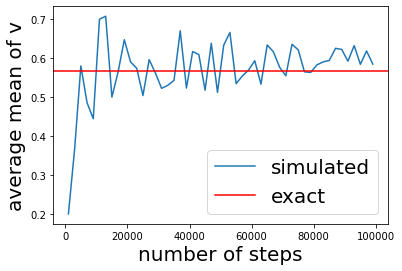

In [23]:
plt.plot(np.arange(1000,100000,2000),mean_list,label='simulated')
plt.axhline(meanExact(kT,hbarOmega), color='r', linestyle='-',label='exact') #plot a horizontal line at the exact value
plt.xlabel("number of steps",fontsize=20)
plt.ylabel("average mean of v",fontsize=20)
plt.legend(fontsize=20)

# Exam Question 11-6:
In this question, we conduct an exact partition function calculation of the two lowest electric states of atomic iodine with it's fourfold degenerate ground electric state ($E=0 \text{ eV}$) and it's twofold degenerate first excited state ($E=0.9427 \text{ eV}$). We then also do a Monte Carlo simulation of this system to calculate the probability of being in the excited state. 

### Exact Partition Function Calculation
Below, we calculate the exact partition function. We do this by using the following formula provided in the book: $$q_{\text{elect}}(T)=g_{e1}+g_{e2}e^{\varepsilon_{e2}/k_BT}+\cdots$$ where we only care about the first two terms. We know that $g_{e1}=4,g_{e2}=2$, and to represent that degeneracy, we follow the hint provided and create a list with the electronic energies that we will randomly pull from. We then calculate the following probability for being in the first excited state:

$$f_{\text{excited}}=\frac{g_{e2}e^{\varepsilon_{e2}/k_BT}}{q_{\text{elect}}(T)}$$

The code we use to complete that task is the below cell. 

In [24]:
energy_list = np.array([0,0,0,0,0.9427,0.9427]) # creates an energy_list which includes degeneracy
energy_list = energy_list*1.6022e-19 # eV to Joules


"""
Function: energyElectric()
Inputs: N/A
Outputs: ground or excited (string)

Task: Given our list energy_list, randomly choose one of the entries in that list. If num==0, we are in the
ground state, otherwise we are in the excited state. 
"""
def energyElectric(): #  decides if we are in the excited or ground state.
    num = np.random.choice(energy_list,size=1)
    if num == 0:
       return "ground"
    if num == 0.9427*1.6022e-19:
       return "excited"

"""
Function: qExact(state,T)
Inputs: state (string), T (float)
Outputs: Q (float)

Task: Calculates the partition function for our system by summing all of the boltzman factors of our 
system. 
"""
def qExact(state,T): 
    """calculate the exact value of the partition function"""
    Q = 0 
    # Just have to sum the boltzman factors of the six states in our system. 
    for energy in energy_list:
        Q = Q + sy.exp(-energy/(constants.Boltzmann*T))
    return Q

""" 
Function: exactProbResult(state,T)
Inputs: state (string), T (float)

Task: Calculates the probability of being in the ground state or excited state given a particular Temperature 
"""
def exactProbResult(state,T):
    if state == 'ground':
        return sy.N(4*sy.exp(-energy_list[0]/(constants.Boltzmann*T))/qExact(state,T))
    elif state == 'excited':
        return sy.N(2*sy.exp(-energy_list[5]/(constants.Boltzmann*T))/qExact(state,T))

In [25]:
print("The exact probability of being in the excited state is {:.2%}".format(exactProbResult('excited',5000)))

The exact probability of being in the excited state is 5.31%


### Monte Carlo Functions

##### Collaborators: Aidan Cosgrove, Casey, Spencer (though we didn't explicitly work together) gave me the idea for my solution
Below, we define the various Monte Carlo (MC) functions required to perform a MC simulation for this electric simulation. These functions follow the same format as the vibrational frequency MC functions. Each functions purpose is described in the string statement above the prespective function. The main functions defined below are the following: calc_energy(), count(samples, entry), MCstep(state,T), runMC(initial_state, temperature, nEquil, num_steps), and MCProbResult(vSamples, vTarget).

In [26]:
"""
Function: calc_energy(state)
Inputs: state (string)
Outputs: state calculationg (float)

Task: Takes in the input 'ground' or 'excited' and returns the associated energy calculation for that energy level in J.
"""
def calc_energy(state):
   if state == "ground":
      return 0
   if state == "excited":
      return 0.9427*1.6022e-19 # Units in Joules
   

"""
Function: count(samples,entry)

Copied and kept entirely the same as the vibrational example. 
"""
def count(samples, entry):
  """making a python equivalent for the Mathematica "Count[]" function.
  "samples" should be your list of samples.
  "entry" should be which kind of entry you'd like to code to count for you.
  these are the same inputs that the Mathematica function would expect."""
  items, counts = np.unique(samples, axis=0, return_counts=True) # tally
  for i in range(len(items)):
    if np.array_equal(items[i],entry):
      return counts[i]

"""
Function: MCStep(state, T)
Inputs: state (string), T (float)

Task: Calculates deltaE between new_state - state, and if deltaE <= 0, then our system does not experience a desired change. 
However, if deltaE > 0, then we will take that change at the probability of the Boltzman distribution for that deltaE. If 
we do not accept the change, then we will return the original state. 
"""
def MCstep(state,T):
    new_state = energyElectric()
    deltaE = calc_energy(new_state) - calc_energy(state)
    if deltaE <= 0:
      return new_state
    else:
      randn = np.random.random()
      if randn < np.exp(-deltaE/(constants.Boltzmann*T)):
        return new_state
      else:
        return state

"""
What we are doing right now is finding the exact partial function. What we want to do with the Monte Carlo 
Simulation is see if we can have it be the same as the exact partial function. Our Monte Carlo simulation will follow
The following formatting:

Function: runMC(initial_state, temperature, nEquil, num_steps)
Inputs: initial_state(string), temperature(float), nEquil(integar), num_steps(integar)
Ouputs: states (list)

Task: Run the MCStep equal to num_steps, and then for every nEquil, we log that state. We then return a list of the states 
we collect from the Monte Carlo simulation. 
"""
def runMC(initial_state, temperature, nEquil, num_steps):
    """Run a Monte Carlo simulation."""
    states = [] # holds all the states
    current_state = initial_state # start either in ground or excited state

    for i in range(num_steps):
        current_state = MCstep(current_state, temperature) # change the state to the new state determined in MCStep
        if i%100 == 0:
            states.append(current_state)
    return states

"""
Function: MCProbResult(vSamples, vTarget)
Inputs: eSamples (list), eTarget(string)
Outputs: count(list, target)/len(eSamples)

Task: Calculates the probability of being either the ground state or the excited state based
on the MC simulation. 
"""
def MCProbResult(eSamples, eTarget):
    """
    Calculate the probability of an energy level given data from a
    Monte Carlo simulation.
    """
    if eTarget == 'ground':
       target = 0
    elif eTarget == 'excited':
       target = 1

    list = []

    """
    Interesting concept below, we only care about the two binaries of 'ground' and 'excited.' Thus, when we count up our list,
    we instead treat ground = 0 and excited = 1. We merely want to count how many we have in either the ground of excited state,
    and calculating that amount is easier when we associate with energy with a number after getting our list. 
    """
    for i in range(len(eSamples)): 
      if eSamples[i] == 'ground':
        list.append(0)
      elif eSamples[i] == 'excited':
        list.append(1)
    return count(list, target)/len(eSamples)


In [27]:
simlist = runMC(energyElectric(),5000,100,10000)
print("The probability of begin in the ground state at a temperature of 5000 is for this simlist is", MCProbResult(simlist, 'excited'))

The probability of begin in the ground state at a temperature of 5000 is for this simlist is 0.03


### Monte Carlo Convergence
Below, we do a convergence test for the Monte Carlo simulation to calculate the probability of being in the 'excited' state.

In [28]:
state = energyElectric() # Pick some random state, between Excited or Ground
temperature = 5000 # in K 
convergenceTest = [] #dont change this; re-initializes the list of outcomes
for nDataCol in np.arange(1000,100000,2000): #dont change this; this specifies how many simulations
    convergenceTest.append(MCProbResult(runMC(state,temperature,100,10000),'excited')) #put something in here to append to the list
# convergenceTest

### Monte Carlo Plot
Below, we plot the MC steps versus the exact calculation of the probability of begin in the excited. There seems to be a large amount of varience for our MC simulation, however, the graph is making the graph look deceiving. The varience is occuring within $\pm 0.02$ of the exact value. 

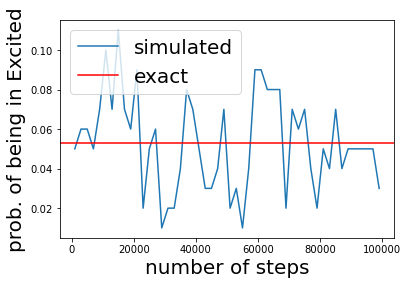

In [29]:
plt.plot(np.arange(1000,100000,2000),convergenceTest,label='simulated')
plt.axhline(exactProbResult('excited',5000), color='r', linestyle='-',label='exact') #plot a horizontal line at the exact value
plt.xlabel("number of steps",fontsize=20)
plt.ylabel("prob. of being in Excited",fontsize=20)
plt.legend(fontsize=20)